In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '__editable__.flax-0.8.2.finder.__path_hook__',
 '/opt/pip/src',
 '/opt/praxis',
 '/opt/paxml',
 '/usr/lib/python3/dist-packages',
 '/notebooks/JAXGym']

In [5]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [45]:
from models.base_model import BaseModel, NormalDistPredictor
from agents.REINFORCE_continuous import ActorCriticContinuous
from trainer import build_trainer

In [24]:
actor_lr = 2e-4
critic_lr = 2e-3

discount = 0.9

iters = 10000

max_episode_steps = 500

env_name = "Pendulum-v1"

In [25]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [46]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(cpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), NormalDistPredictor(output_size = action_size, logvar_init_value = 0.1)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = ActorCriticContinuous(discount)
    
    all_rewards = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, env, env_params, obs_size, max_episode_steps)
    
    carry = (actor, critic, all_rewards, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

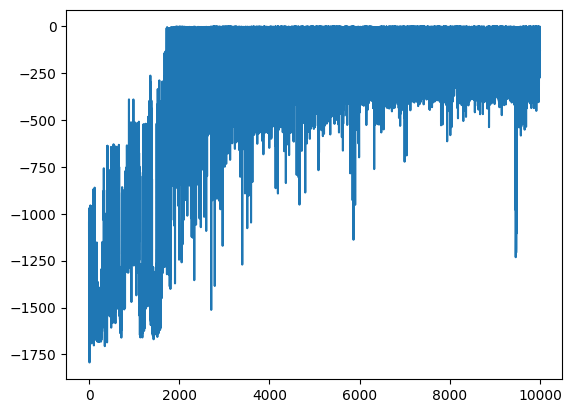

In [47]:
plt.plot(carry[-2][:])
plt.show()